In [1]:
%matplotlib inline
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
py.init_notebook_mode(connected = True)

In [5]:
import opendatasets as od

In [9]:
od.download('https://www.kaggle.com/datasnaek/mbti-type')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: riyadabbou
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 24.4M/24.4M [00:03<00:00, 6.78MB/s]


We'll use following variables:-

    train_data for the data frame mbti_1.csv
    forum_data for ForumMessages.csv

to indicate that this is unprocessed data that which we might clean, filter and modify to prepare a data frame that's ready for analysis.

In [11]:
train_data = pd.read_csv('mbti_1.csv')
forum_data = pd.read_csv('ForumMessages.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

In [12]:
train_data.shape

(8675, 2)

In [13]:
train_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


our train_data contains two features: "type" is the predicted class and "posts" the feature that contains the messages used 
to predict the mbti type.

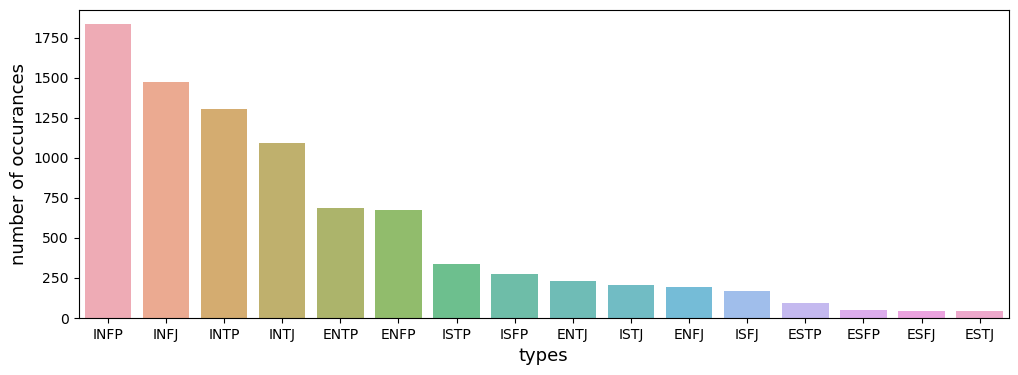

In [14]:
cns_srs = train_data['type'].value_counts()
plt.figure(figsize = (12,4))
sns.barplot(x=cns_srs.index, y=cns_srs.values, alpha=0.8)
plt.ylabel("number of occurances",fontsize = 13)
plt.xlabel("types",fontsize = 13)
plt.show()

we did some data exploration to see how the raw data looks and to see how important our features were
for distinguishing types across the MBTI personalities.
Below are plots further showing the type imbalances in our data using
Stripplot which is used to draw a categorical scatterplot using jitter to reduce overplotting.

<Axes: xlabel='type', ylabel='words_per_comment'>

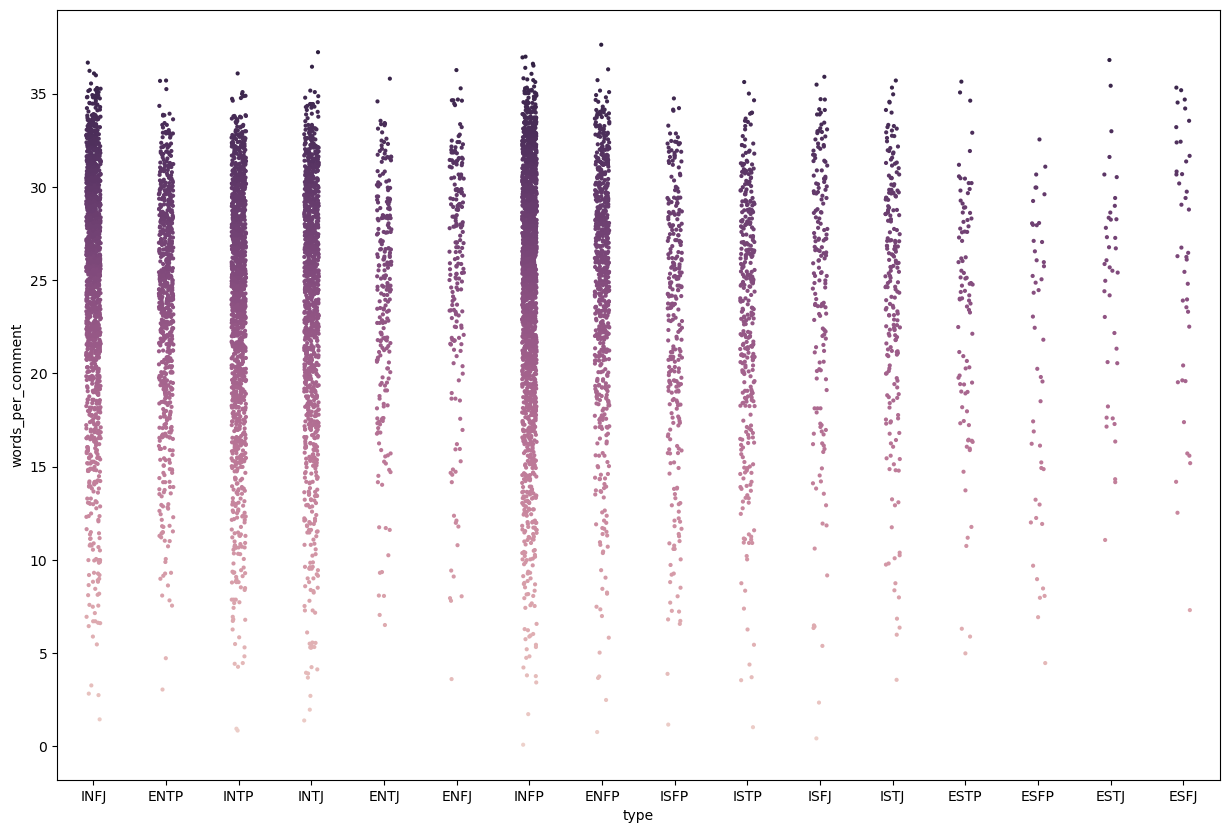

In [15]:
df = train_data.copy()
#this function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))

plt.figure(figsize=(15,10))
sns.stripplot(x="type", y="words_per_comment", data=df, jitter=True, size=3, hue="words_per_comment", legend=False)

This plot further shows clearly that our dataset is imbalanced(skewed to the right) since most comments are from types that use either inroverted or extroverted intuition (NI or NE) as a (Dominant/parent) function which does not reflect their overall destribution in society (Less than 30%).

JOINT PLOT

Plotting the joint plot between the no. of words that occur in each comment v/s their variance

Jointplot is seaborn library specific and can be used to quickly visualize and analyze the relationship between two variables and describe their individual distributions on the same plot.

A distribution plot at the top for the column on the x-axis, a distribution plot on the right for the column on the y-axis and a scatter plot in between that shows the mutual distribution of data for both the columns. The area below the histogram helps in calculating the PDF, i.e. Probability Density function and the highest peak of the curve is the mean of distribution.

<Figure size 1500x1000 with 0 Axes>

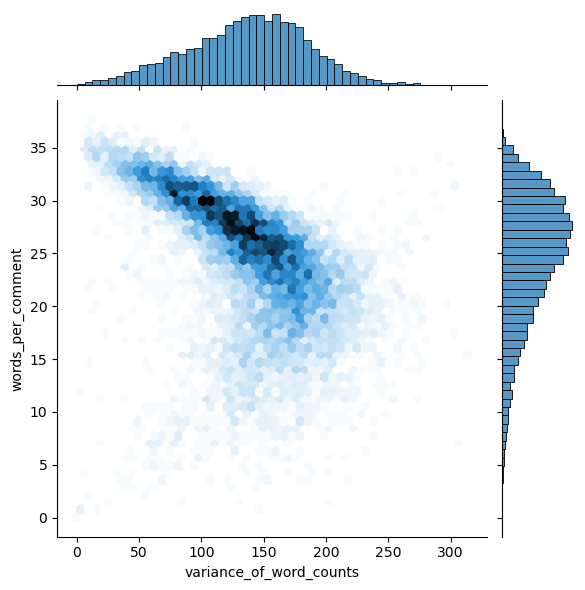

In [16]:
plt.figure(figsize=(15,10))
sns.jointplot(x="variance_of_word_counts", y="words_per_comment", data=df, kind="hex")

<Figure size 2500x500 with 0 Axes>

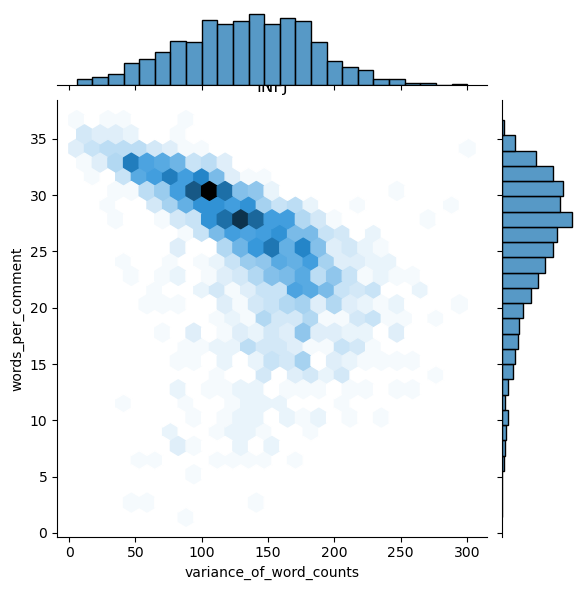

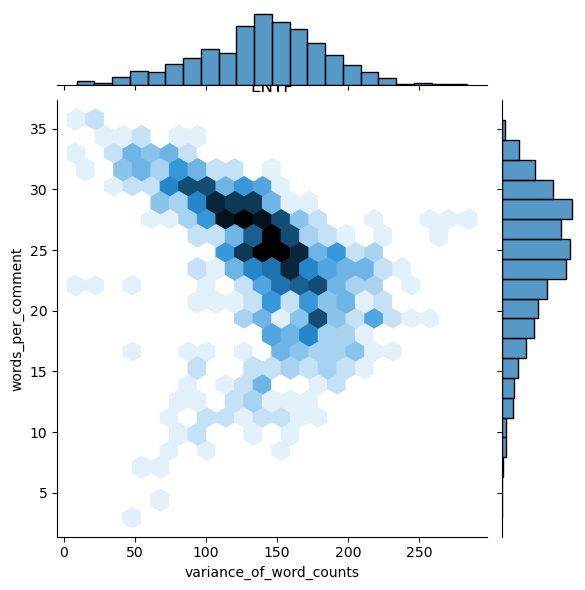

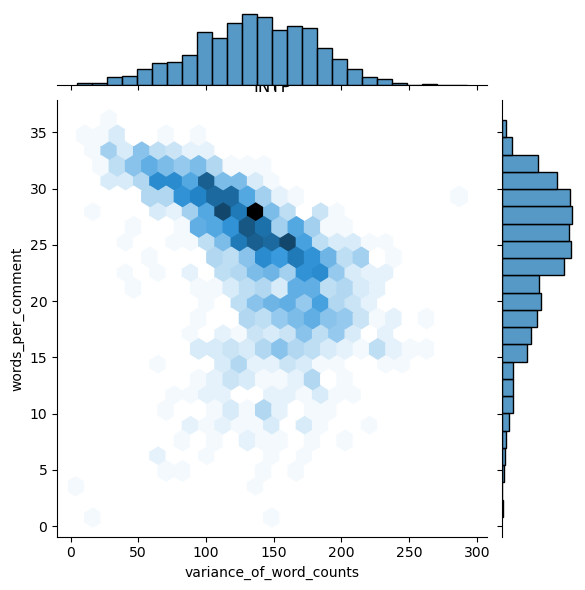

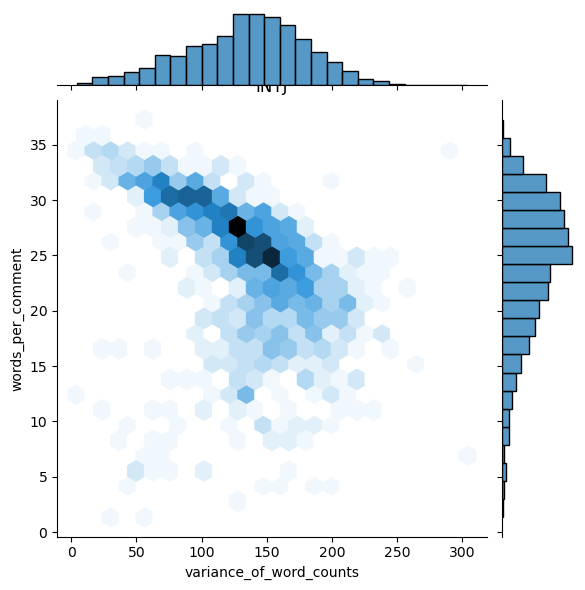

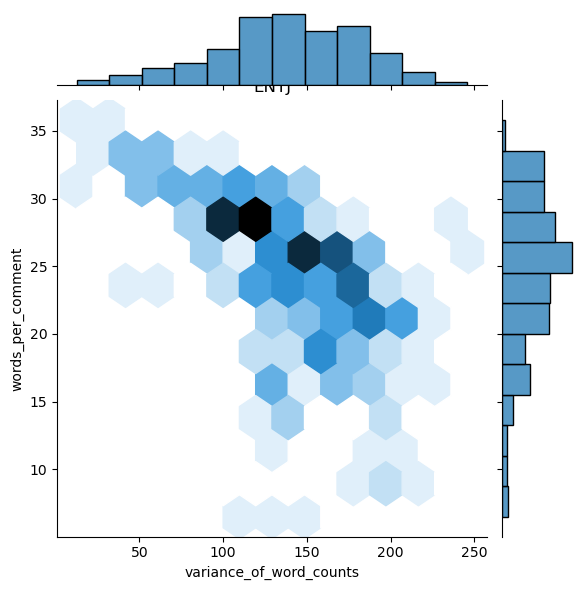

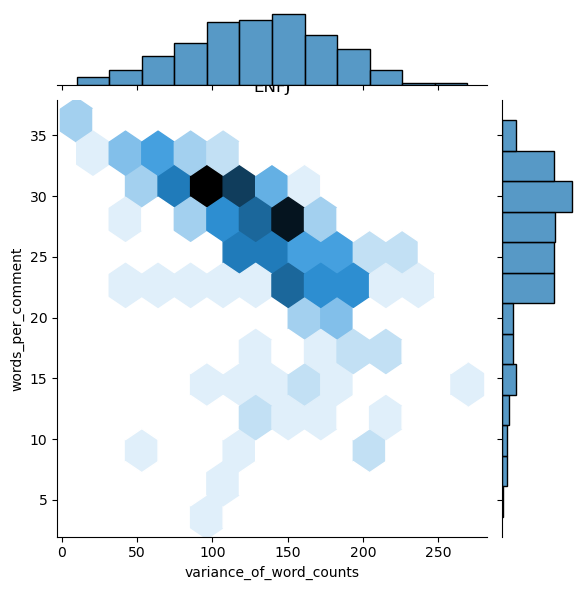

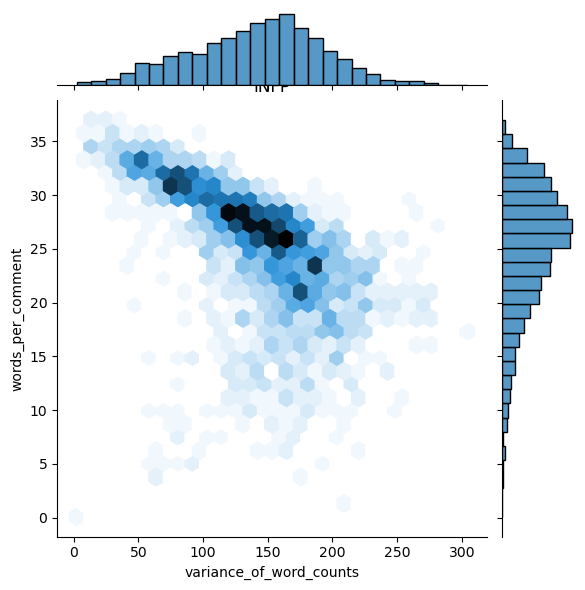

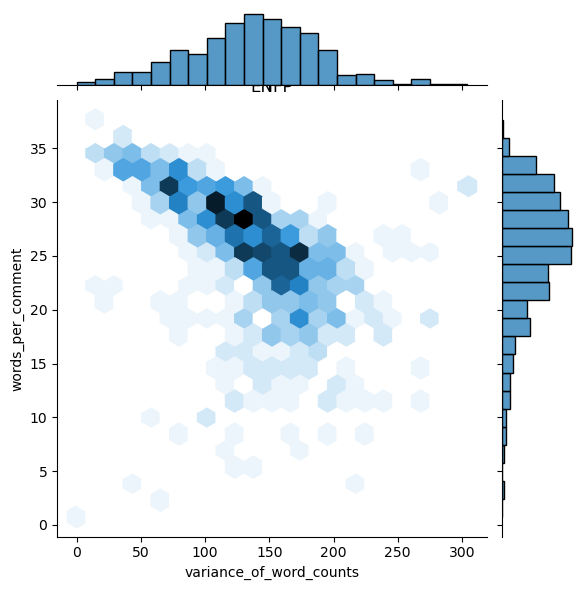

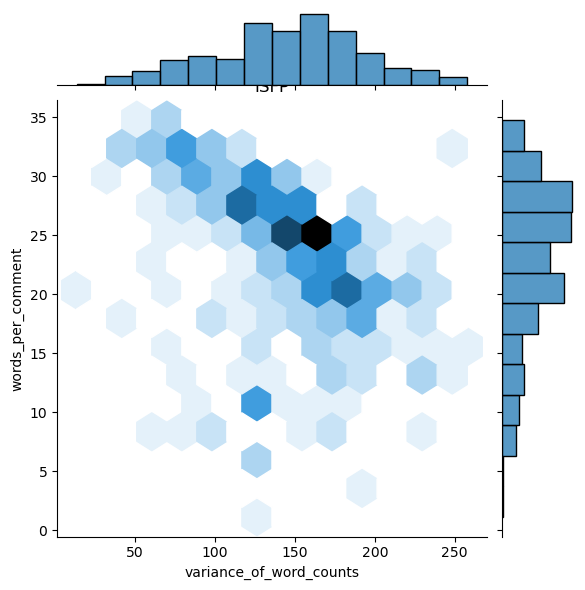

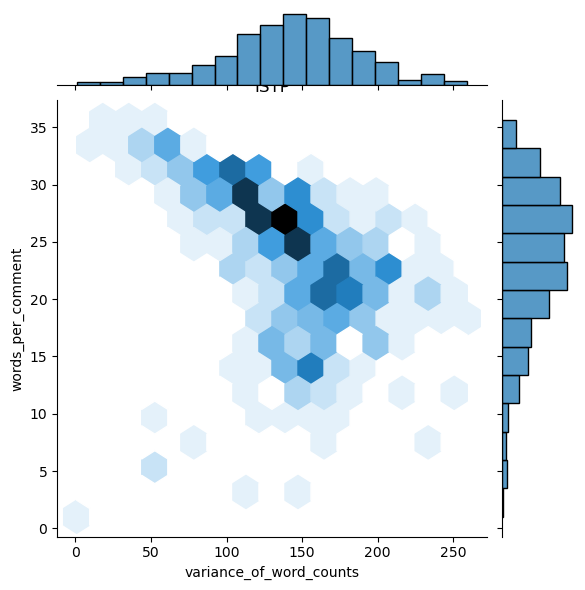

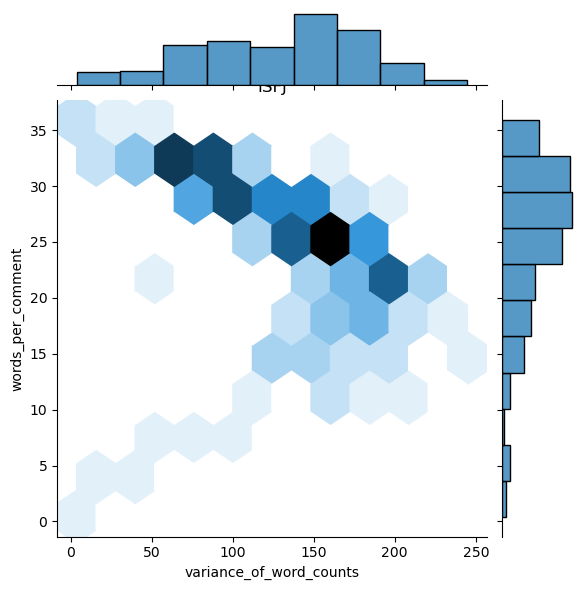

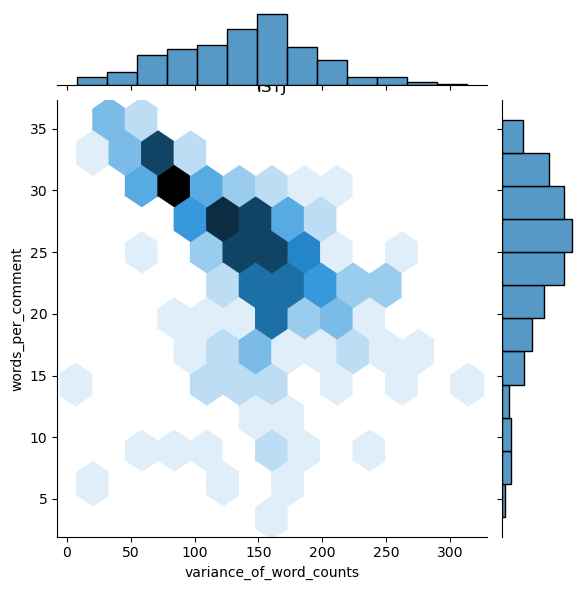

In [17]:
def plot_jointplot(mbti_type, axs, titles):
    df_1 = df[df['type'] == mbti_type]
    sns.jointplot("variance_of_word_counts", "words_per_comment", data=df_1, kind="hex", ax = axs, title = titles)

plt.figure(figsize=(25, 5))    
i = df['type'].unique()
k = 0

for m in range(1,3):
  for n in range(1,7):
    df_1 = df[df['type'] == i[k]]
    sns.jointplot(x="variance_of_word_counts", y="words_per_comment", data=df_1, kind="hex" )
    plt.title(i[k])
    k+=1
plt.show()

For all the plots you can see that most of the posts have words btw 100-150 and most of no. of words per comment by a user is nearly 25 to 30 range.

Exception to this case is for the plots for ISPJ and ISTJ, but this maybe due to the fact that there are significantly less no. of posts available for these personality types (further shown by the bar plots below)

We can see that there is no correlation observed between variance of word count and the words per comment.
But there is a weak negative correlation observed between the 2 features for few personalities. Maybe this could be due to the low no. of posts available for that type in the given Kaggle dataset.
No useful inferences can be made by analyzing the individual jointplots as the total no of posts for each personlaity type is different.

Hence, these features will not be useful in building our Personality prediction model.

## Handling Missing Values

Checking if there are any missing or null values present in the dataset.

In [18]:
print('Forum Missing Values:')
print(forum_data.isnull().sum())

Forum Missing Values:
Id                             0
ForumTopicId                   0
PostUserId                     0
PostDate                       0
ReplyToForumMessageId    1091327
Message                     7147
Medal                    1228309
MedalAwardDate           1218356
dtype: int64


In [19]:
print('Training Missing Values:')
print(train_data.isnull().sum())

Training Missing Values:
type     0
posts    0
dtype: int64


There are no null values present in the mbti dataset

Since the number of missing values for "Message" feature in "forum_data" dataset is small compared to the number of samples we will just fill it with blank space.

In [20]:
forum_data['Message'] = forum_data['Message'].fillna('')

print('Forum Missing Values:')
print(forum_data.isnull().sum())

Forum Missing Values:
Id                             0
ForumTopicId                   0
PostUserId                     0
PostDate                       0
ReplyToForumMessageId    1091327
Message                        0
Medal                    1228309
MedalAwardDate           1218356
dtype: int64


In [21]:
print(forum_data['PostUserId'].value_counts())

PostUserId
3012786     22420
8273630     10562
75976       10500
1723677      9526
10654180     8212
            ...  
6286314         1
3520141         1
6286118         1
4718882         1
18485417        1
Name: count, Length: 349259, dtype: int64


In [22]:
forum_data_agg = forum_data.groupby('PostUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()

In [24]:
forum_data_agg['PostUserId'].duplicated().sum()

0

In [25]:
#function to clean data
import string
def clean_text(text):
    #get rid of html and seperators
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r'  ', text) 
    text = re.sub(r'http\S+', r'  ', text)
    #get rid of punctuation
    text = text.replace('.', '  ')
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    #get rid of numbers
    text = ''.join(i for i in text if not i.isdigit())
    return text

In [26]:
train_data['clean_posts'] = train_data['posts'].apply(clean_text)

C:\Users\mcs\AppData\Local\Temp\ipykernel_21400\4226603675.py:5: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [27]:
train_data['clean_posts'][1]

'Im finding the lack of me in these posts very alarming    Sex can be boring if its in the same position often   For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary   There isnt enough        Giving new meaning to Game theory    Hello ENTP Grin  Thats all it takes   Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins    This  Lack of Balance and Hand Eye Coordination    Real IQ test I score    Internet IQ tests are funny   I score s or higher    Now like the former responses of this thread I will mention that I dont believe in the IQ test   Before you banish        You know youre an ENTP when you vanish from a site for a year and a half return and find people are still commenting on your posts and liking your ideasthoughts   You know youre an ENTP when you                I over think things sometimes   I go by the old She

In [28]:
forum_data_agg['clean_messages'] = forum_data_agg['Message'].apply(clean_text)

C:\Users\mcs\AppData\Local\Temp\ipykernel_21400\4226603675.py:5: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [22]:
forum_data_agg['clean_messages'][1]

'Hi Tanya Kaggle will maintain a rating system   If you win but youre ineligible for prize money you will still get a strong rating  Anthony GiovanniThanks for your feedback   Using the forum to give feedback is a good idea   It allows others to see and comment on suggestions   We might set up a proper feedback forum but for the moment this topic will have to suffice   I also agree that the forum is a bit clunky   However we have a large list of feature requests and only limited resources for the moment  it might take us some time to address this   Apologies   I dont think the prize money in this competition is that relevant the prize is relatively small   Correct me if Im wrong but I think contestants are driven by intrinsic factors  A karma system that rewards forum posts is a good idea   Again apologies for any delay in implementing this there are lots of features on our to do list  Anthony Manish thanks for the feedback   The site is hosted on an Amazon EC server on the east coast 

## Cleaning Data

In [29]:
#function to split string by uppercase
def split_uppercase(text):
    text_list = text.split()
    new_list = []
    for i in text_list:
        if i.isupper() == False: #don't split acronyms
            word = re.sub(r'([A-Z])', r' \1', i)
            new_list.append(word)
        else:
            word = i
            new_list.append(word)
    words = ' '.join(new_list)
    return words
            

In [32]:
forum_data_agg['clean_messages'] = forum_data_agg['clean_messages'].apply(split_uppercase)

In [31]:
forum_data_agg['clean_messages'][1]

' Hi  Tanya  Kaggle will maintain a rating system  If you win but youre ineligible for prize money you will still get a strong rating  Anthony  Giovanni Thanks for your feedback  Using the forum to give feedback is a good idea  It allows others to see and comment on suggestions  We might set up a proper feedback forum but for the moment this topic will have to suffice I also agree that the forum is a bit clunky  However we have a large list of feature requests and only limited resources for the moment it might take us some time to address this  Apologies I dont think the prize money in this competition is that relevant the prize is relatively small  Correct me if  Im wrong but I think contestants are driven by intrinsic factors A karma system that rewards forum posts is a good idea  Again apologies for any delay in implementing this there are lots of features on our to do list  Anthony  Manish thanks for the feedback  The site is hosted on an  Amazon EC server on the east coast of  Ame

In [33]:
#function to stem words
def stem_text(text):
    stemmer = SnowballStemmer('english')
    words_list = text.split()
    new_list = []
    for i in words_list:
        word = stemmer.stem(i)
        new_list.append(word)
        
    words = new_list
    words = ' '.join(words)
    return words

In [34]:
train_data['clean_posts'] = train_data['clean_posts'].apply(stem_text)

In [35]:
train_data['clean_posts'][1]

'im find the lack of me in these post veri alarm sex can be bore if it in the same posit often for exampl me and my girlfriend are current in an environ where we have to creativ use cowgirl and missionari there isnt enough give new mean to game theori hello entp grin that all it take than we convers and they do most of the flirt while i acknowledg their presenc and return their word with smooth wordplay and more cheeki grin this lack of balanc and hand eye coordin real iq test i score internet iq test are funni i score s or higher now like the former respons of this thread i will mention that i dont believ in the iq test befor you banish you know your an entp when you vanish from a site for a year and a half return and find peopl are still comment on your post and like your ideasthought you know your an entp when you i over think thing sometim i go by the old sherlock holm quot perhap when a man has special knowledg and special power like my own it rather encourag him to seek a complex

In [36]:
forum_data_agg['clean_messages'] = forum_data_agg['clean_messages'].apply(stem_text)

In [37]:
forum_data_agg['clean_messages'][1]

"hi tanya kaggl will maintain a rate system if you win but your inelig for prize money you will still get a strong rate anthoni giovanni thank for your feedback use the forum to give feedback is a good idea it allow other to see and comment on suggest we might set up a proper feedback forum but for the moment this topic will have to suffic i also agre that the forum is a bit clunki howev we have a larg list of featur request and onli limit resourc for the moment it might take us some time to address this apolog i dont think the prize money in this competit is that relev the prize is relat small correct me if im wrong but i think contest are driven by intrins factor a karma system that reward forum post is a good idea again apolog for ani delay in implement this there are lot of featur on our to do list anthoni manish thank for the feedback the site is host on an amazon ec server on the east coast of america it a fast server but the site has been more popular than we expect were current

C:\Users\mcs\AppData\Local\Temp\ipykernel_21400\3706355944.py:9: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



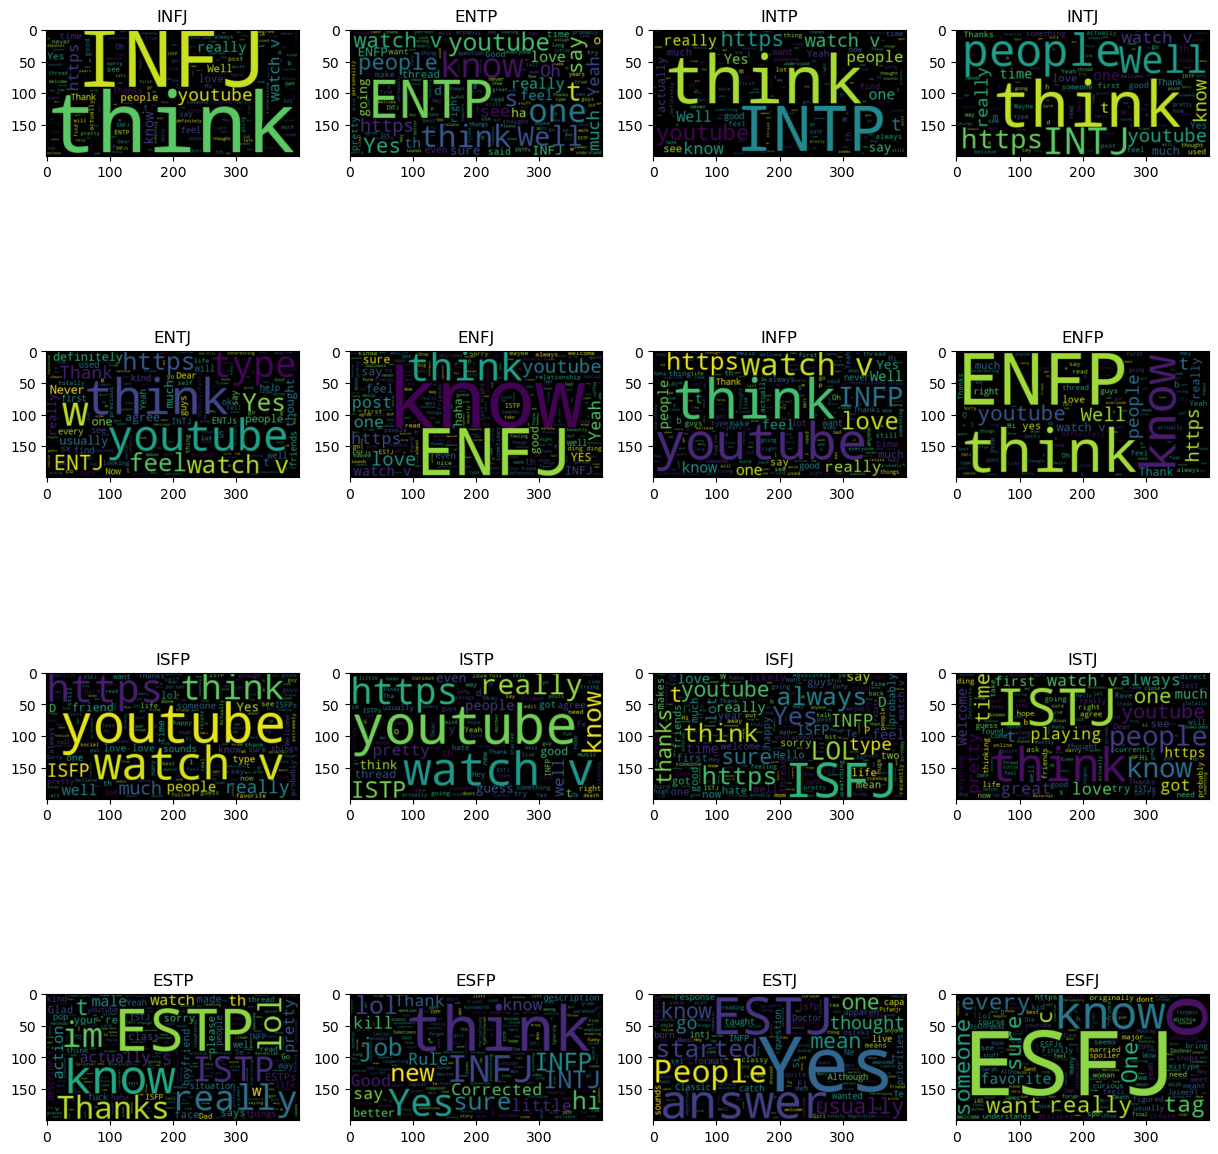

In [38]:
import wordcloud
from wordcloud import WordCloud

fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(15,len(df['type'].unique())))
k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

## Classifier Building

### Importing libraries

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}

### ExtraTreesClassifier with SVD

In [40]:
etc = ExtraTreesClassifier(n_estimators = 20, max_depth=4, n_jobs = -1)
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)
model = Pipeline([('tfidf1', tfidf), ('tsvd1', tsvd), ('etc', etc)])

In [41]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [42]:
np.random.seed(1)

results = cross_validate(model, train_data['clean_posts'], train_data['type'], cv=kfolds, scoring=scoring, n_jobs=-1)

In [43]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_acc']),
                                                  np.std(results['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_f1_micro']),
                                            np.std(results['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results['test_neg_log_loss']),
                                                 np.std(-1*results['test_neg_log_loss'])))

CV Accuracy: 0.3846 (+/- 0.0111)
CV F1: 0.3846 (+/- 0.0111)
CV Logloss: 2.0504 (+/- 0.0088)


As the dataset is very unbalanced F1 score is a better metric than accuracy

## Alternative Modles

Let's try if we can find a more accuracy model, although we haven't got a lot of data

### Naive Bayes

In [44]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1, 1), 
                         stop_words='english',
                         lowercase = True, 
                         max_features = 5000)

model_nb = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB())])

results_nb = cross_validate(model_nb, train_data['clean_posts'], train_data['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [45]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_acc']),
                                                  np.std(results_nb['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),
                                            np.std(results_nb['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']),
                                                 np.std(-1*results_nb['test_neg_log_loss'])))

CV Accuracy: 0.5609 (+/- 0.0102)
CV F1: 0.5609 (+/- 0.0102)
CV Logloss: 6.3486 (+/- 0.3465)


### Logistic Regression

In [73]:
np.random.seed(1)

from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression

tfidf2 = CountVectorizer(ngram_range=(1, 1), stop_words='english', lowercase = True, max_features = 5000)

model_lr = Pipeline([('tfidf1', tfidf2), ('lr', LogisticRegression(class_weight="balanced", C=0.005))])

results_lr = cross_validate(model_lr, train_data['clean_posts'], train_data['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [74]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_acc']),
                                                  np.std(results_lr['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']),
                                            np.std(results_lr['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr['test_neg_log_loss']),
                                                 np.std(-1*results_lr['test_neg_log_loss'])))

CV Accuracy: 0.6572 (+/- 0.0122)
CV F1: 0.6572 (+/- 0.0122)
CV Logloss: 1.2891 (+/- 0.0209)


In [48]:
for i in df['type'].unique():
    print(df[df['type'] == i])

      type                                              posts  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
6     INFJ  'No, I can't draw on my own nails (haha). Thos...   
8     INFJ  I'm not sure, that's a good question. The dist...   
10    INFJ  'One time my parents were fighting over my dad...   
12    INFJ  'Joe santagato - ENTP|||ENFJ or  ENTP?   I'm n...   
...    ...                                                ...   
8645  INFJ  'I play cello, and I'm also a classically trai...   
8650  INFJ  'I think the real question is whether INFJs ca...   
8655  INFJ  'I find that poster and your facial expression...   
8656  INFJ  Rim  In some approximate order, it seems like ...   
8669  INFJ  'I'm not sure about a method for picking out I...   

      words_per_comment  variance_of_word_counts  
0                 11.12                 135.2900  
6                 26.58                 151.3664  
8                 14.76                 207.1124  
10             

In [49]:
train_data.head()

,type,posts,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp and intj moment sportscent not top ten pl...
1,ENTP,'I'm finding the lack of me in these posts ver...,im find the lack of me in these post veri alar...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one of cours to which i say i know that m...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoy our convers the other day es...
4,ENTJ,'You're fired.|||That's another silly misconce...,your fire that anoth silli misconcept that app...


In [55]:
list_personality = train_data['type']
clean_posts = train_data['clean_posts']
to_train_data = pd.concat([list_personality,clean_posts], axis=1).values

In [56]:
X = to_train_data

In [57]:
Y = list_personality

In [58]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)
X_encoded = label_encoder.fit_transform(X[0])

In [59]:
np.unique(y_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

# **Kaggle Users Personality Prediction**
As our Last model `(Logistic Regression)` gives high accuracy so we will apply our last model to whole kaggle users comments.

Let's see what is the most common kaggle user personalities

In [63]:
model_lr.fit(train_data['clean_posts'], train_data['type'])
pred_all = model_lr.predict(forum_data_agg['clean_messages'])

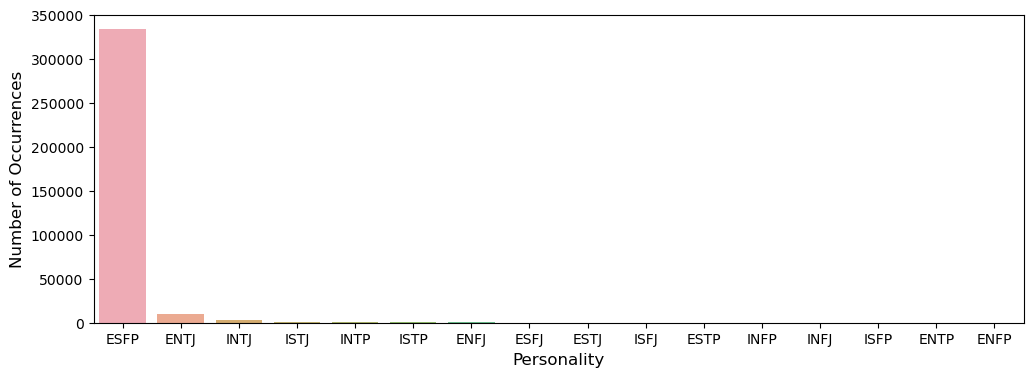

In [64]:
cnt_all = np.unique(pred_all, return_counts=True)

pred_df = pd.DataFrame({'personality': cnt_all[0], 'count': cnt_all[1]},
                      columns=['personality', 'count'], index=None)

pred_df.sort_values('count', ascending=False, inplace=True)

plt.figure(figsize=(12,4))
sns.barplot(x=pred_df['personality'], y=pred_df['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.show()

In [65]:
pred_df['percent'] = pred_df['count']/pred_df['count'].sum()

In [66]:
pred_df['description'] = pred_df['personality'].apply(lambda x: ' '.join([mbti[l] for l in list(x)]))

In [67]:
pred_df

,personality,count,percent,description
5,ESFP,333495,0.954864,Extroversion Sensing Feeling Perceiving
2,ENTJ,9825,0.028131,Extroversion Intuition Thinking Judging
10,INTJ,2888,0.008269,Introversion Intuition Thinking Judging
14,ISTJ,1330,0.003808,Introversion Sensing Thinking Judging
11,INTP,623,0.001784,Introversion Intuition Thinking Perceiving
15,ISTP,341,0.000976,Introversion Sensing Thinking Perceiving
0,ENFJ,301,0.000862,Extroversion Intuition Feeling Judging
4,ESFJ,151,0.000432,Extroversion Sensing Feeling Judging
6,ESTJ,126,0.000361,Extroversion Sensing Thinking Judging
12,ISFJ,49,0.000140,Introversion Sensing Feeling Judging


In [68]:
import plotly.graph_objs as go

In [69]:
import plotly.offline as py

In [70]:
labels = pred_df['description']
sizes = pred_df['percent']*100
 
trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title='Kaggle Personality Distribution')
 
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# **Conclusion**

Apparently the most common Kaggle users personality is ESFP (Extroversion Sensing Feeling Perceiving), but we are getting this conclusion based on users comments: it is reasonable to think that users who participate more writting comments are more extrovert. Our sample data don't came from all Kaggle user population, it comes from Kaggle users who write comments so, our conclusion can't be applied to all Kaggle users, only to those who write comments. Farthermore, more accuracy models could be obtained with more data.

In [75]:
from joblib import dump

In [78]:
model_lr.fit(train_data['clean_posts'], train_data['type'])

C:\Users\mcs\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('tfidf1',
                 CountVectorizer(max_features=5000, stop_words='english')),
                ('lr', LogisticRegression(C=0.005, class_weight='balanced'))])

In [80]:
model_lr.predict(["hi"])

array(['ESFP'], dtype=object)

In [79]:
dump(value = model_lr,filename="model.joblib")

['model.joblib']